# Otto商品分类——Logistic 回归

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用
缺省参数LogisticRegression、
LogisticRegression + GridSearchCV （可用LogisticRegressionCV代替）进行参数调优。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

第一名：https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
第二名：http://blog.kaggle.com/2015/06/09/otto-product-classification-winners-interview-2nd-place-alexander-guschin/

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [2]:
# 读取数据
# 请自行在log(x+1)特征和tf_idf特征上尝试，并比较不同特征的结果，
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_FE_train_org.csv")
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,0.016393,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.018182,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
1,2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.013158,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
2,3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.013158,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
3,4,0.016393,0.0,0.0,0.014286,0.315789,0.1,0.131579,0.000000,0.0,...,0.000000,0.015385,0.029851,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.018182,0.000000,0.000000,0.0,0.0,0.007692,0.0,0.0,0.0,Class_1


## 准备数据

In [3]:
y_train = train['target']   
X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## 默认参数的Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [7]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
#数据集比较大，采用3折交叉验证
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=3, scoring='neg_log_loss')
#%timeit loss_sparse = cross_val_score(lr, X_train_sparse, y_train, cv=3, scoring='neg_log_loss')
print ('logloss of each fold is: ',-loss)
print ('cv logloss is:', -loss.mean())

('logloss of each fold is: ', array([0.79764035, 0.79738555, 0.79737369]))
('cv logloss is:', 0.7974665293185456)


## Logistic Regression + GridSearchCV

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 
目标函数为：J =  C* sum(logloss(f(xi), yi)) + penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
1. 设置参数搜索范围
2. 生成学习器实例（参数设置）
3. 生成GridSearchCV的实例（参数设置）
4. 调用GridSearchCV的fit方法

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [ 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression(solver='liblinear')
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=3, scoring='neg_log_loss',n_jobs = 4,)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [9]:
# examine the best model
print(-grid.best_score_)
print(grid.best_params_)

0.6728466060484329
{'penalty': 'l1', 'C': 100}


/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


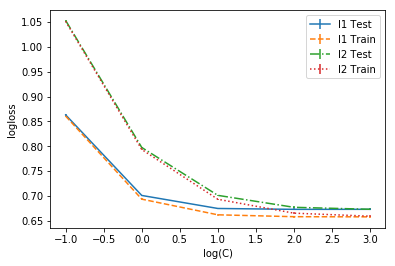

In [10]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
#for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
plt.errorbar(x_axis, -test_scores[:,0], yerr=test_stds[:,0] ,label = penaltys[0] +' Test',linestyle='-')
plt.errorbar(x_axis, -train_scores[:,0], yerr=train_stds[:,0] ,label = penaltys[0] +' Train',linestyle='--')

plt.errorbar(x_axis, -test_scores[:,1], yerr=test_stds[:,1] ,label = penaltys[1] +' Test',linestyle='-.')
plt.errorbar(x_axis, -train_scores[:,1], yerr=train_stds[:,1] ,label = penaltys[1] +' Train',linestyle=':')


plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'logloss' )
plt.savefig('LogisticGridSearchCV_C.png' )

plt.show()

上图给出了L1正则和L2正则下、不同正则参数C对应的模型在训练集上测试集上的logloss。
可以看出在训练集上C越大（正则越少）的模型性能越好；
但在测试集上当C=100时性能最好（L1正则）

## 保存模型，用于后续测试

In [26]:
import cPickle

cPickle.dump(grid.best_estimator_, open("Otto_L1_org.pkl", 'wb'))